In [1]:
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
import json

In [2]:
# 初始化VGG19模型
model = torchvision.models.vgg19(pretrained=True)
for param in model.parameters():
    param.requires_grad = False


/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
# 图像预处理
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size, size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

# 绘制显著图
# def plot_saliency(saliency, index, nrows, ncols):
#     plt.subplot(nrows, ncols, index + 1)
#     plt.imshow(saliency[0], cmap=plt.cm.hot)
#     # plt.axis('off')
def plot_saliency(saliency, index, nrows, ncols):
    ax = plt.subplot(nrows, ncols, index + 1)
    plt.imshow(saliency[0], cmap=plt.cm.hot)
    
    # 设置坐标轴刻度
    ax.set_xticks([0, 0.25 * X.shape[-1], 0.5 * X.shape[-1], 0.75 * X.shape[-1], X.shape[-1]])
    ax.set_yticks([0, 0.25 * X.shape[-2], 0.5 * X.shape[-2], 0.75 * X.shape[-2], X.shape[-2]])
    
    # 设置坐标轴标签
    ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1])
    ax.set_yticklabels([0, 0.25, 0.5, 0.75, 1])

In [4]:
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [5]:
# 获取 ImageNet 类别标签
response = requests.get('https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json')
labels = json.loads(response.text)

# 将模型输出转换为概率分布
def output_to_probabilities(output):
    probabilities = torch.nn.Softmax(dim=1)(output)
    return probabilities.squeeze().detach().cpu().numpy()

# 输出 VGG19 预测结果
print("VGG19 Predictions:")
for i in range(25):
    img = Image.open(f'datasets/images/{i}.png')
    X = preprocess(img)
    scores = model(X)
    
    # 计算概率分布
    probabilities = output_to_probabilities(scores)
    
    # 获取前 5 个最可能的类别及其概率
    top5_probs, top5_indices = torch.topk(torch.tensor(probabilities), 5)
    top5_probs = top5_probs.numpy()
    top5_classes = [labels[index] for index in top5_indices.numpy()]
    
    # 输出前 5 个最可能的类别及其概率
    print(f"Image {i} top 5 predicted classes:")
    for prob, label in zip(top5_probs, top5_classes):
        print(f"  {label}: {prob*100:.2f}%")


VGG19 Predictions:
Image 0 top 5 predicted classes:
  hay: 100.00%
  croquet ball: 0.00%
  barrel: 0.00%
  acorn: 0.00%
  baseball: 0.00%
Image 1 top 5 predicted classes:
  quail: 86.64%
  American robin: 10.25%
  king penguin: 0.90%
  American dipper: 0.56%
  partridge: 0.50%
Image 2 top 5 predicted classes:
  Tibetan Mastiff: 99.42%
  Tibetan Terrier: 0.58%
  Newfoundland: 0.00%
  Chow Chow: 0.00%
  Bernese Mountain Dog: 0.00%
Image 3 top 5 predicted classes:
  Border Terrier: 99.74%
  Griffon Bruxellois: 0.17%
  Norfolk Terrier: 0.05%
  Cairn Terrier: 0.01%
  Norwich Terrier: 0.01%
Image 4 top 5 predicted classes:
  brown bear: 99.97%
  polar bear: 0.03%
  otter: 0.00%
  wild boar: 0.00%
  American black bear: 0.00%
Image 5 top 5 predicted classes:
  soap dispenser: 99.67%
  toilet seat: 0.09%
  space heater: 0.05%
  switch: 0.04%
  paper towel: 0.03%
Image 6 top 5 predicted classes:
  kimono: 14.61%
  French horn: 10.05%
  bow tie: 6.74%
  couch: 6.32%
  military uniform: 5.33%
Ima

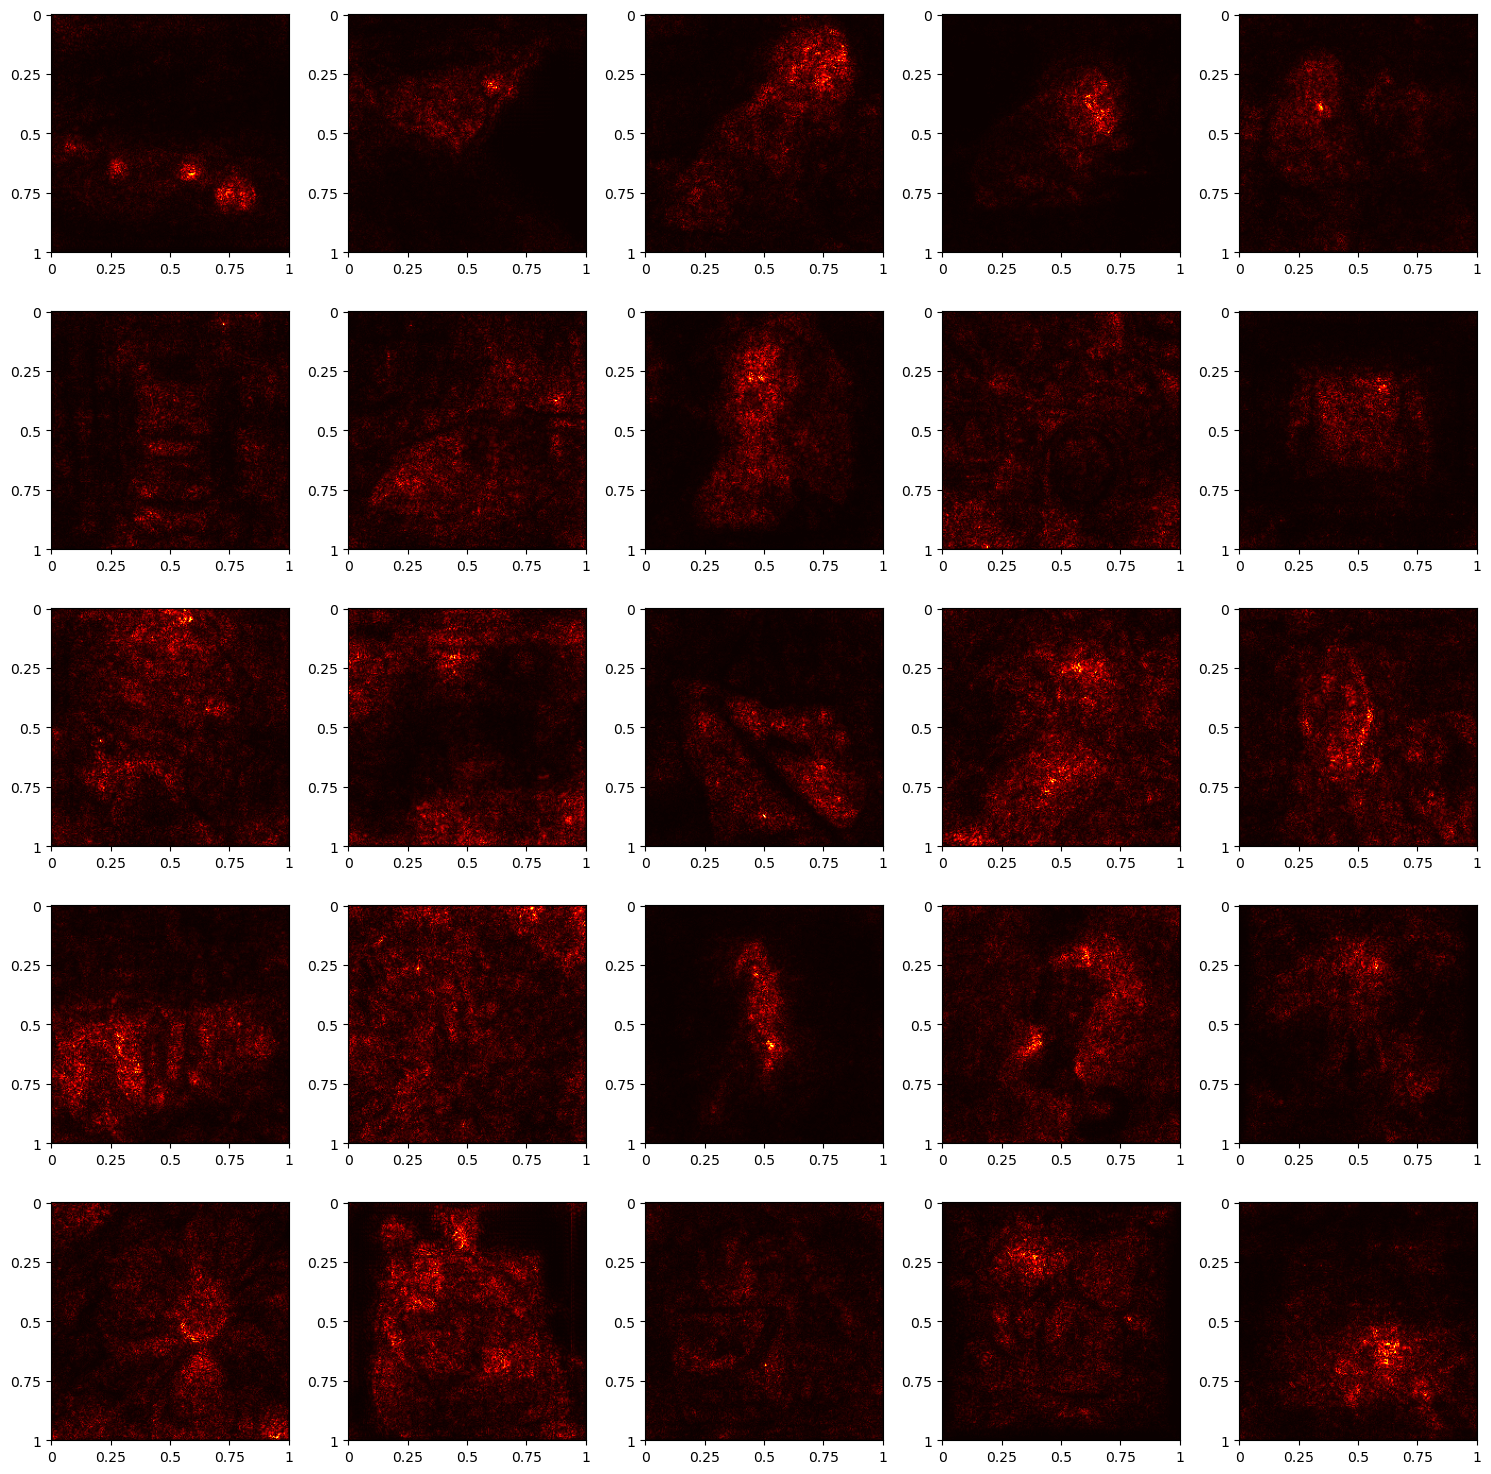

In [6]:
# 创建一个 5x5 网格来绘制显著图
nrows = 5
ncols = 5

# 设置图形大小
plt.figure(figsize=(ncols * 3, nrows * 3))

for i in range(25):
    img = Image.open(f'datasets/images/{i}.png')

    X = preprocess(img)
    # 我们需要找到关于输入图像的梯度，所以我们需要对 X 调用 requires_grad_
    X.requires_grad_()
    scores = model(X)
    # 获取最高分对应的索引和最高分本身
    score_max_index = scores.argmax()
    score_max = scores[0, score_max_index]
    score_max.backward()
    saliency, _ = torch.max(X.grad.data.abs(), dim=1)

    # 绘制当前图像的显著图
    plot_saliency(saliency, i, nrows, ncols)

plt.tight_layout()
plt.show()